In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_location = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname = font_location).get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

from tslearn.clustering import TimeSeriesKMeans

from tslearn.metrics import cdist_dtw

np.random.seed(0)

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [4]:

plt.style.use('ggplot')



산업별 매출 실적 데이터를 불러옵니다.

기준은 2015년 매출 실적입니다(2015년 매출실적=100)

고려한 산업은 총 14개로 목록은 다음과 같습니다.

'식료품', '섬유', '의복모피', '의료물질·의약품', '전자·영상·통신장비', '자동차', '가구', '건설업', '숙박업', 

'정보통신업', '부동산업', '사업시설·사업지원·임대업', '예술·스포츠·여가', '서비스업'



In [5]:
industry= pd.read_excel('업종별 매출 실적_reduce.xlsx')
industry['시점'] = industry['시점'].astype('str').apply(lambda x: x[:4]+'-'+x[5:8]) # 시점을 예쁘게 보이기 위한 처리
industry['시점']=pd.to_datetime(industry['시점'])

In [6]:
industry.head()

,시점,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업
0,2017-01-01,83,58,75,125,94,98,71,81,63,94,77,89,74,85
1,2017-02-01,86,59,79,115,103,92,74,80,84,93,83,88,67,85
2,2017-03-01,81,57,68,110,100,99,74,82,81,98,84,90,86,87
3,2017-04-01,91,66,79,110,108,92,71,86,98,98,78,89,76,89
4,2017-05-01,91,56,82,107,113,75,71,80,77,87,86,91,80,85


In [7]:
types=list(industry.columns)[1:] # 산업 리스트

industry 데이터에서 계절성 제거를 위해 차분을 진행한 후 이동평균을 구했습니다. 이동평균은 4개월을 기준으로 구하였습니다.

음수가 나오면 전년 대비 매출실적이 감소한 것이고 양수가 나오면 전년 대비 매출실적이 증가한 것 입니다

In [8]:
industry_temp=industry.copy()

industry_temp.drop(columns=['시점']
                ,inplace=True)

In [9]:

industry_temp=industry_temp.diff(12).rolling(4,min_periods=1,center=True).mean()

industry_temp['시점']=industry['시점']
industry_temp.dropna(inplace=True)

In [10]:
industry_temp.head()

,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업,시점
11,18.000000,12.000000,8.00,-12.000000,5.000000,-35.000000,5.000000,3.000000,10.000000,-13.00,3.000000,1.000000,-8.0,1.0,2017-12-01
12,15.500000,9.000000,7.00,-5.000000,-1.000000,-33.500000,-1.000000,2.000000,-1.000000,-4.00,2.500000,-4.000000,-13.5,1.5,2018-01-01
13,14.666667,10.333333,12.00,0.666667,-6.333333,-34.666667,-2.666667,0.666667,-1.666667,-2.00,-0.666667,-5.666667,-17.0,1.0,2018-02-01
14,11.750000,11.750000,10.25,-1.500000,-11.000000,-33.250000,-0.500000,-2.250000,-4.750000,-1.25,-0.500000,-3.750000,-16.0,0.0,2018-03-01
15,6.500000,14.500000,8.75,1.000000,-20.750000,-22.000000,0.000000,-3.000000,-1.500000,3.25,-5.000000,-6.250000,-12.5,0.5,2018-04-01


In [11]:
industry_ma=industry.rolling(4,min_periods=1,center=True).mean()
industry_ma['시점']=industry['시점']

#나중에 그래프를 그리기 위해 계절성 차분 안하고 이동평균을 구한 것 입니다.

2020년 1월을 기준으로 코로나 전,후를 구분하였습니다

In [12]:
industry_af=industry_temp.iloc[25:]
industry_bf=industry_temp.iloc[1:25]

industry_bf.drop(columns=['시점']
                ,inplace=True)
industry_af.drop(columns=['시점']
                ,inplace=True)
industry_temp.drop(columns=['시점']
                ,inplace=True)

In [13]:
industry_bf.reset_index(drop=True, inplace=True)

industry_af.reset_index(drop=True, inplace=True)

In [14]:
industry_bf.head()
# 코로나 이전

,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업
0,15.500000,9.000000,7.00,-5.000000,-1.000000,-33.500000,-1.000000,2.000000,-1.000000,-4.00,2.500000,-4.000000,-13.50,1.5
1,14.666667,10.333333,12.00,0.666667,-6.333333,-34.666667,-2.666667,0.666667,-1.666667,-2.00,-0.666667,-5.666667,-17.00,1.0
2,11.750000,11.750000,10.25,-1.500000,-11.000000,-33.250000,-0.500000,-2.250000,-4.750000,-1.25,-0.500000,-3.750000,-16.00,0.0
3,6.500000,14.500000,8.75,1.000000,-20.750000,-22.000000,0.000000,-3.000000,-1.500000,3.25,-5.000000,-6.250000,-12.50,0.5
4,5.000000,17.750000,11.75,-2.250000,-22.500000,-14.500000,5.500000,-5.500000,4.250000,3.00,-9.750000,-2.750000,-8.25,0.5


In [15]:
industry_af.head()
# 코로나 이후

,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업
0,-2.25,-3.50,-15.75,8.25,1.75,1.5,-1.50,-4.50,3.25,10.50,0.50,0.25,9.75,-1.50
1,-4.25,-5.25,-24.25,5.75,-1.00,-11.5,-3.75,-3.75,-14.00,1.75,-2.50,-8.50,-9.25,-8.75
2,-9.50,-17.50,-35.75,-3.75,-5.00,-29.0,-6.25,-7.25,-31.75,-8.75,-2.50,-15.00,-24.25,-15.75
3,-10.50,-27.00,-44.50,-7.00,-15.00,-47.5,-10.25,-10.25,-56.50,-18.00,-2.25,-21.25,-40.25,-21.25
4,-10.25,-35.75,-51.00,-8.50,-15.75,-60.5,-10.25,-10.50,-67.50,-23.50,-3.25,-26.25,-38.50,-24.00


# 시계열 clustering

산업별 군집 분석을 실시합니다. 시계열 데이터를 군집 분석의 기준은 dtw(Dynamic time warping, 동적 시간 워핑)입니다.

dtw는 시계열 데이터들의 유사성을 보기 위한 알고리즘입니다.

유사한 정도를 보기 위해서는 거리값을 계산하는데, 

단순히  유클리드 거리로 계산하면, 같은 시점의 거리를 계산하기 때문에 속도가 반영이 안됩니다. 즉, 두 그래프의 모양이 비슷함에도 불구하고 시점이 살짝이라도 차이가 나면 값이 커집니다.

그래서 동일한 패턴이어도, 속도가 다르면,  시작점이 다르면 다르게 인식합니다.  

이를 보완하기 위한 것이 DTW입니다.

DTW에서는 거리가 가장 짧은 시점(유사도가 높은 시작점)을 찾습니다.

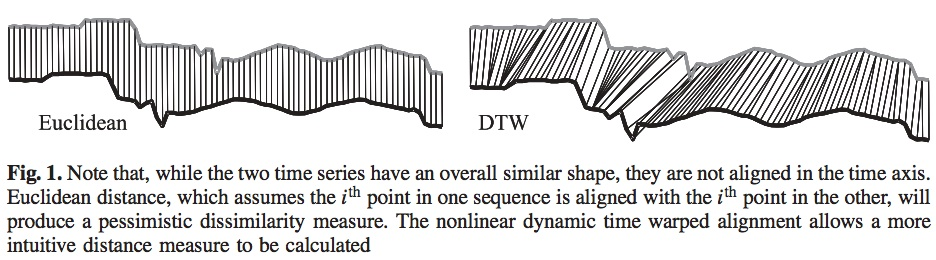

사진 출처: http://practicalquant.blogspot.com/2012/10/mining-time-series-with-trillions-of.html


각 산업들의 매출 실적 데이터끼리 dtw를 계산합니다.

코로나 이전, 이후를 따로 계산하였습니다.

In [16]:
industry_bf_T=industry_bf.T
industry_af_T=industry_af.T


In [17]:
dtw_bf=pd.DataFrame(cdist_dtw(industry_bf_T))
dtw_bf.columns=types
dtw_bf.index=types
dtw_bf.head()

,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업
식료품,0.000000,13.927640,41.464426,37.627284,58.350712,97.185211,46.072030,29.791638,37.448669,37.665007,37.096908,44.013177,66.135488,25.536466
섬유,13.927640,0.000000,33.803353,47.501389,58.528068,93.811054,36.050216,35.254629,27.964511,41.683913,37.990039,51.778374,61.565570,36.022080
의복모피,41.464426,33.803353,0.000000,76.152214,75.259505,101.799674,28.901893,42.748376,53.333724,66.910855,60.580238,64.372344,76.864329,55.213223
의료물질·의약품,37.627284,47.501389,76.152214,0.000000,30.867099,57.985211,37.219973,38.807932,39.143876,11.061696,23.069942,22.565029,38.754928,22.331001
전자·영상·통신장비,58.350712,58.528068,75.259505,30.867099,0.000000,57.851342,25.369629,41.355421,50.276044,26.943872,16.679370,23.583039,40.529910,36.582289


In [18]:
dtw_af=pd.DataFrame(cdist_dtw(industry_af_T))
dtw_af.columns=types
dtw_af.index=types
dtw_af.head()

,식료품,섬유,의복모피,의료물질·의약품,전자·영상·통신장비,자동차,가구,건설업,숙박업,정보통신업,부동산업,사업시설·사업지원·임대업,예술·스포츠·여가,서비스업
식료품,0.000000,39.942233,85.991440,18.044120,23.878163,108.296789,6.350306,5.841661,159.677627,20.217567,9.463747,19.720618,62.349374,18.784783
섬유,39.942233,0.000000,43.462787,50.550580,38.895605,59.211720,43.782766,43.182832,131.519353,24.171408,50.365884,15.924082,40.296902,19.909343
의복모피,85.991440,43.462787,0.000000,107.915605,98.463262,28.509989,95.969541,95.619944,87.646346,69.187949,101.721263,61.190561,30.525718,59.204037
의료물질·의약품,18.044120,50.550580,107.915605,0.000000,19.661899,125.646826,12.813025,17.194557,178.315556,27.694514,14.731156,29.938479,78.968744,36.695916
전자·영상·통신장비,23.878163,38.895605,98.463262,19.661899,0.000000,115.196601,18.040656,21.469132,178.990592,30.122090,28.384757,24.084198,79.687715,35.041146


dtw 값들 끼리의 거리를 계산하여 군집분석을 합니다.

우선 코로나 이전 데이터의 군집분석을 실시합니다.

데이터는 2018년~2019년 산업별 매출실적 데이터입니다.

군집의 갯수를 정하기 위해 Inertia value를 사용하였습니다

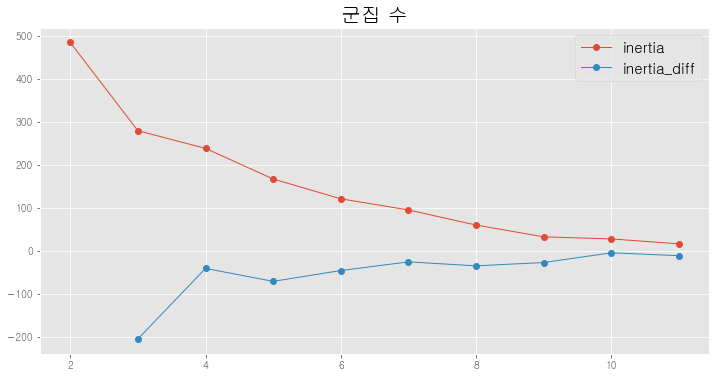

In [35]:
inertia_list = []

for i in range(2, 12):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", 
                          max_iter=50,random_state=14).fit(industry_temp[1:25].reset_index(drop=True).T) 
    inertia_list.append(km.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(2, 12)), inertia_list, marker='o', linewidth=1,label='inertia')
plt.plot(np.array(range(2, 12)), pd.Series(inertia_list).diff(), marker='o', linewidth=1,label='inertia_diff')
plt.title('군집 수',fontsize=20)
plt.legend(fontsize=15)

plt.show()

위 그래프에서 파란 선은 inertia value이고 붉은 선은 indertia value의 차분값입니다. 

저희는 6개의 군집을 사용하기로 했습니다

In [20]:
np.random.seed(0)
n_cluster = 6
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", max_iter=50,random_state=14).fit(industry_bf_T) 
rlt_tsm = km.predict(industry_bf_T)

my_dict_bf = dict((i, []) for i in range(0, n_cluster))

for i in range(len(rlt_tsm)):
    my_dict_bf[rlt_tsm[i]].append(list(types)[i])

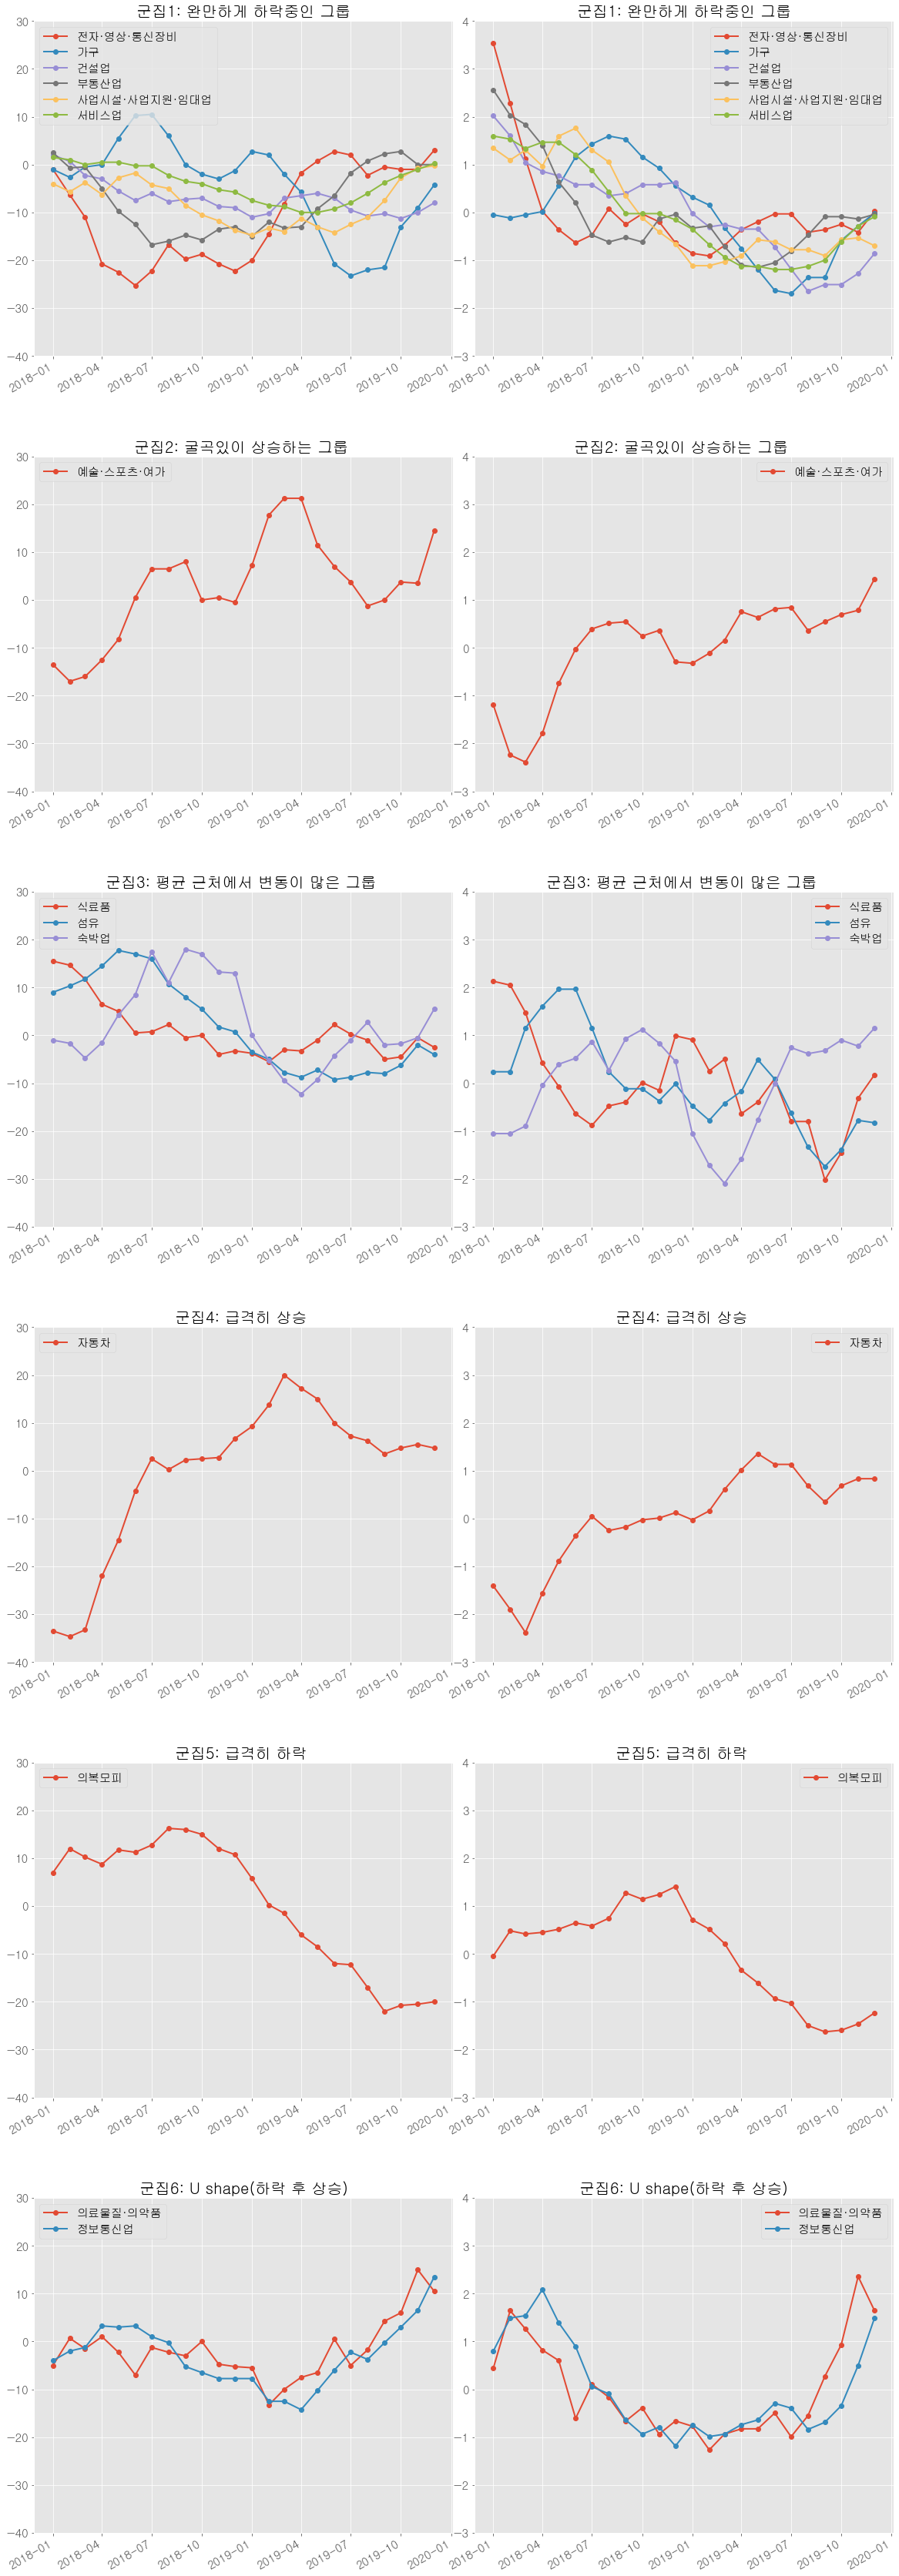

In [30]:
fig, ax = plt.subplots(n_cluster,2,figsize=(20,10*n_cluster))

for j in range(0,n_cluster):
    plt.setp(ax[j,0].get_xticklabels(), rotation=30, ha='right')
    plt.setp(ax[j,1].get_xticklabels(), rotation=30, ha='right')
    plt.setp(ax[j,0].get_xticklabels(), fontsize =15)
    plt.setp(ax[j,1].get_xticklabels(), fontsize =15)
    plt.setp(ax[j,0].get_yticklabels(), fontsize =15)
    plt.setp(ax[j,1].get_yticklabels(), fontsize =15)
    for i in my_dict_bf[j]:
        ax[j,0].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),
                     np.array(industry_temp[[i]][1:25]),marker='o', linewidth=2,label=i)
        ax[j,1].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),
                     np.array(industry_ma[[i]][12:36].transform(lambda x: (x - x.mean()) / x.std())),
                     marker='o', linewidth=2,label=i)
    ax[j,0].set_ylim(-40,30)
    ax[j,1].set_ylim(-3,4)
    ax[j,0].legend(loc='upper left',fontsize=15)
    ax[j,1].legend(loc='upper right',fontsize=15)
ax[0,0].set_title('군집1: 완만하게 하락중인 그룹',fontsize=20)
ax[0,1].set_title('군집1: 완만하게 하락중인 그룹',fontsize=20)
ax[1,0].set_title('군집2: 굴곡있이 상승하는 그룹 ',fontsize=20)
ax[1,1].set_title('군집2: 굴곡있이 상승하는 그룹 ',fontsize=20)
ax[2,0].set_title('군집3: 평균 근처에서 변동이 많은 그룹 ',fontsize=20)
ax[2,1].set_title('군집3: 평균 근처에서 변동이 많은 그룹 ',fontsize=20)
ax[3,0].set_title('군집4: 급격히 상승 ',fontsize=20)
ax[3,1].set_title('군집4: 급격히 상승 ',fontsize=20)
ax[4,0].set_title('군집5: 급격히 하락 ',fontsize=20)
ax[4,1].set_title('군집5: 급격히 하락 ',fontsize=20)
ax[5,0].set_title('군집6: U shape(하락 후 상승)',fontsize=20)
ax[5,1].set_title('군집6: U shape(하락 후 상승)',fontsize=20)

plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.show()

왼쪽에 위치한 그래프들은 전년 동월 대비 증감(차분 값)의 이동평균을, 오른쪽 그래프는 원 데이터의 이동평균 수치입니다.

### 군집1: 완만하게 하락중인 그룹 
-'전자·영상·통신장비', '가구', '건설업', '부동산업', '사업시설·사업지원·임대업', '서비스업'

### 군집2: 굴곡있이 상승하는 그룹 
-'예술·스포츠·여가'

### 군집3: 평균 근처에서 변동이 많은 그룹 
-'식료품', '섬유', '숙박업'

### 군집4: 급격히 상승 
-'자동차'

### 군집5: 급격히 하락 
-'의복모피'

### 군집6: U shape(하락 후 상승) 
-'의료물질·의약품', '정보통신업'

코로나 이후 데이터의 군집분석을 실시합니다.

데이터는 2020년 1월~10월 산업별 매출실적 데이터입니다.


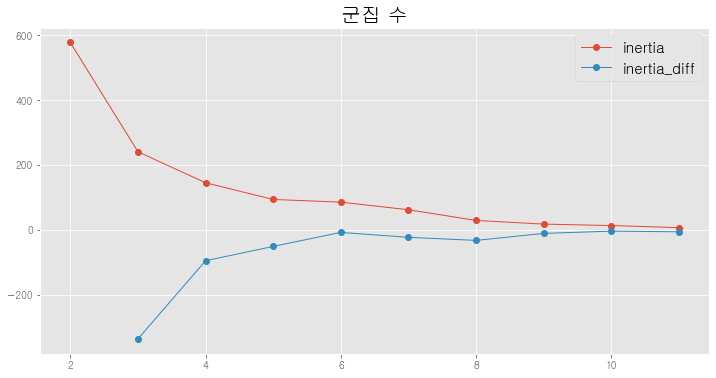

In [34]:
inertia_list = []

for i in range(2, 12):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=50,random_state=14).fit(industry_temp[25:].reset_index(drop=True).T) 
    inertia_list.append(km.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(2, 12)), inertia_list, marker='o', linewidth=1,label='inertia')
plt.plot(np.array(range(2, 12)), pd.Series(inertia_list).diff(), marker='o', linewidth=1,label='inertia_diff')
plt.title('군집 수',fontsize=20)
plt.legend(fontsize=15)

plt.show()

코로나 이전 데이터와 마찬가지로 6개의 군집을 만들기로 하였습니다

In [23]:
np.random.seed(0)
n_cluster = 6
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw",
                      max_iter=50,random_state=14).fit(industry_af_T)

rlt_tsm = km.predict(industry_af_T)

my_dict_af = dict((i, []) for i in range(0, n_cluster))

for i in range(len(rlt_tsm)):
    my_dict_af[rlt_tsm[i]].append(list(types)[i])

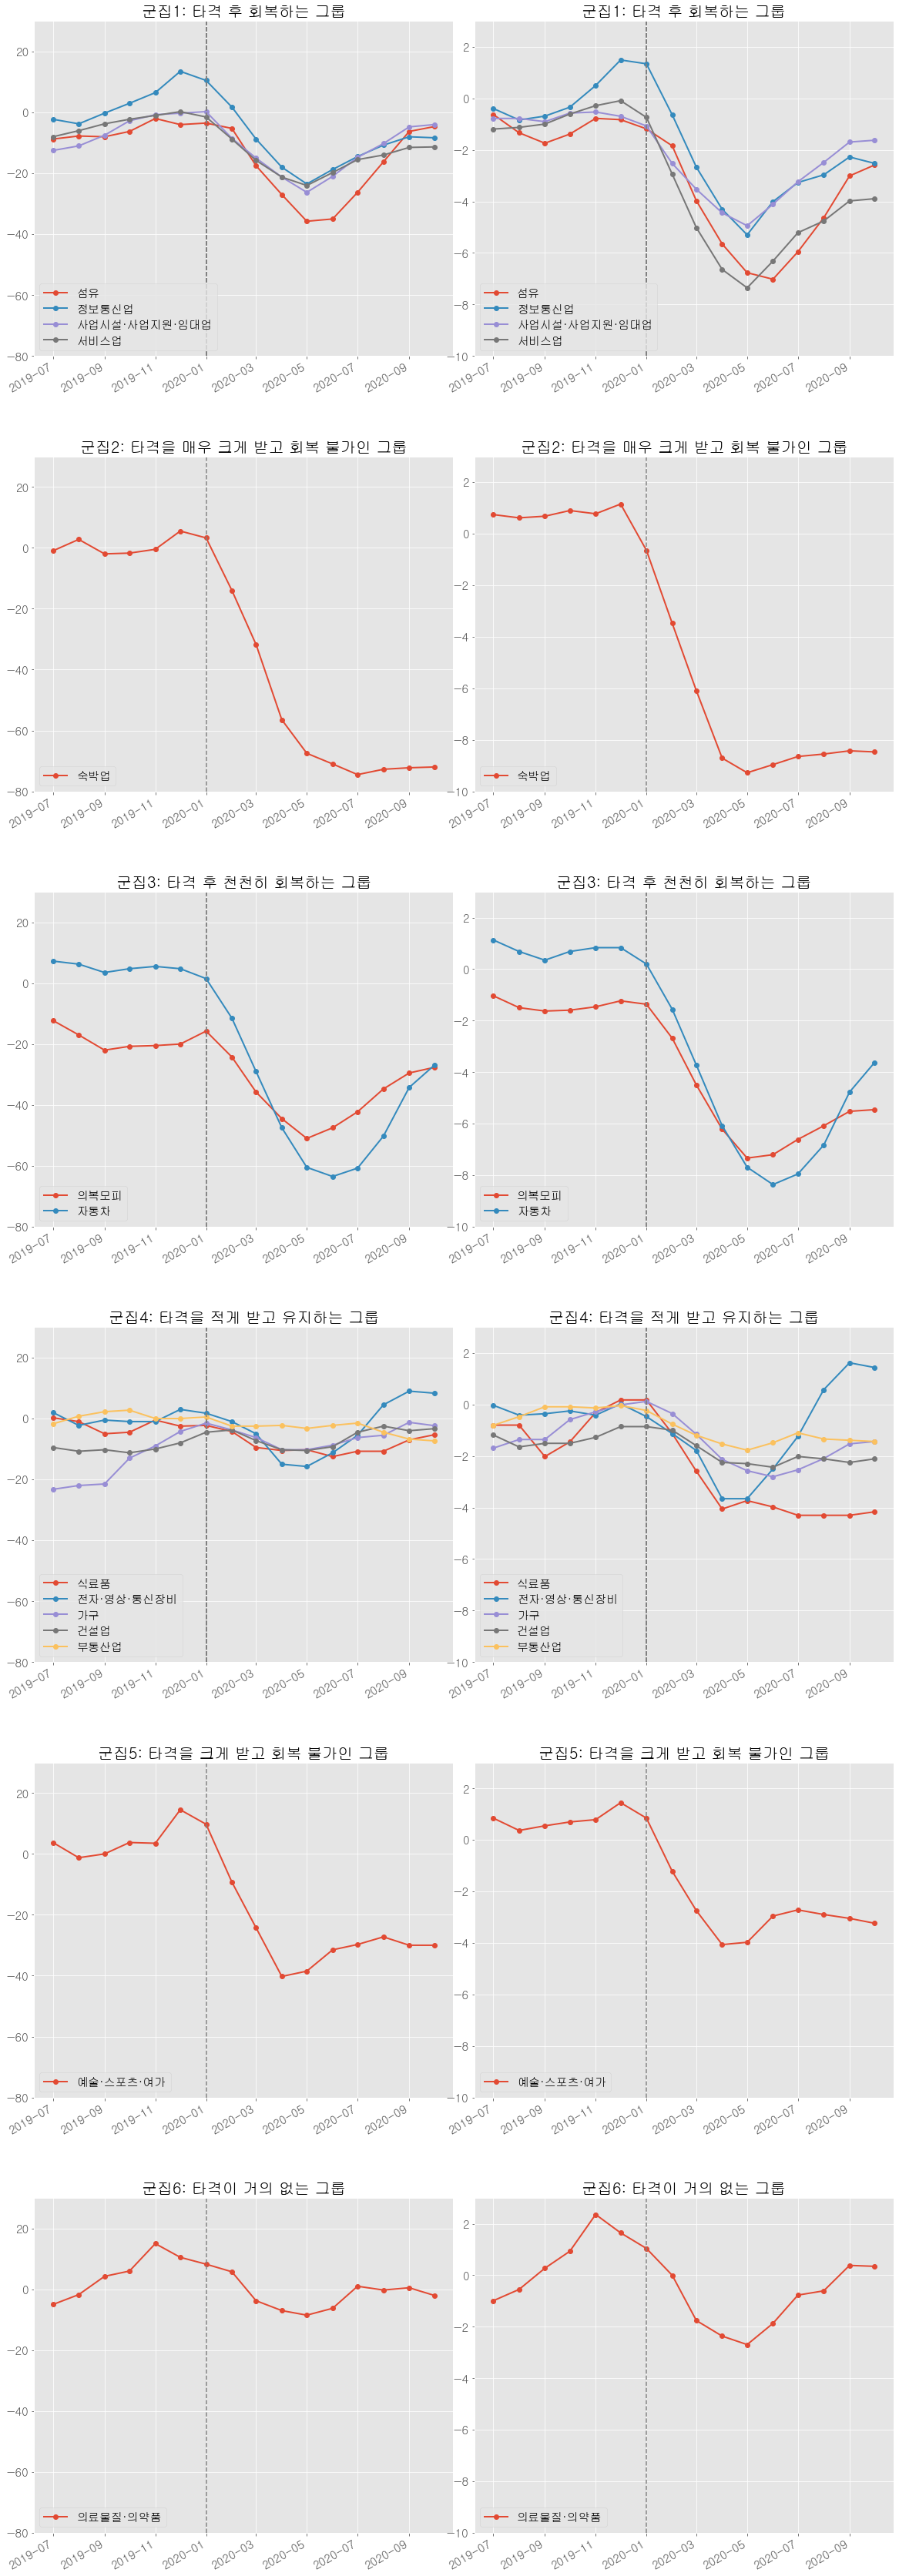

In [29]:
fig, ax = plt.subplots(n_cluster,2,figsize=(20,10*n_cluster))

for j in range(0,n_cluster):
    plt.setp(ax[j,0].get_xticklabels(), rotation=30, ha='right')
    plt.setp(ax[j,1].get_xticklabels(), rotation=30, ha='right')
    plt.setp(ax[j,0].get_xticklabels(), fontsize =15)
    plt.setp(ax[j,1].get_xticklabels(), fontsize =15)
    plt.setp(ax[j,0].get_yticklabels(), fontsize =15)
    plt.setp(ax[j,1].get_yticklabels(), fontsize =15)
    for i in my_dict_af[j]:
        ax[j,0].plot(np.array(industry[['시점']].iloc[30:].reset_index(drop=True)),
                     np.array(industry_temp[[i]][19:]),marker='o', linewidth=2,label=i)
        ax[j,1].plot(np.array(industry[['시점']].iloc[30:].reset_index(drop=True)),
                     np.array(industry_ma[[i]].transform(lambda x: (x - industry_ma[12:36][i].mean()) / industry_ma[12:36][i].std())[30:]),
                     marker='o', linewidth=2,label=i)
        ax[j,0].axvline(x=industry['시점'][36],linestyle ='--',color='grey') 
        ax[j,1].axvline(x=industry['시점'][36],linestyle ='--',color='grey') 
    ax[j,0].set_ylim(-80,30)
    ax[j,1].set_ylim(-10,3)
    ax[j,0].legend(loc='lower left',fontsize=15)
    ax[j,1].legend(loc='lower left',fontsize=15)
    
ax[0,0].set_title('군집1: 타격 후 회복하는 그룹',fontsize=20)
ax[0,1].set_title('군집1: 타격 후 회복하는 그룹',fontsize=20)
ax[1,0].set_title('군집2: 타격을 매우 크게 받고 회복 불가인 그룹',fontsize=20)
ax[1,1].set_title('군집2: 타격을 매우 크게 받고 회복 불가인 그룹',fontsize=20)
ax[2,0].set_title('군집3: 타격 후 천천히 회복하는 그룹',fontsize=20)
ax[2,1].set_title('군집3: 타격 후 천천히 회복하는 그룹',fontsize=20)
ax[3,0].set_title('군집4: 타격을 적게 받고 유지하는 그룹',fontsize=20)
ax[3,1].set_title('군집4: 타격을 적게 받고 유지하는 그룹',fontsize=20)
ax[4,0].set_title('군집5: 타격을 크게 받고 회복 불가인 그룹',fontsize=20)
ax[4,1].set_title('군집5: 타격을 크게 받고 회복 불가인 그룹',fontsize=20)
ax[5,0].set_title('군집6: 타격이 거의 없는 그룹',fontsize=20)
ax[5,1].set_title('군집6: 타격이 거의 없는 그룹',fontsize=20)

plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.show()

왼쪽에 위치한 그래프들은 전년 동월 대비 증감(차분 값)의 이동평균을, 오른쪽 그래프는 원 데이터의 이동평균 수치입니다.

### 군집1: 타격 후 회복하는 그룹
-'섬유', '정보통신업', '사업시설·사업지원·임대업', '서비스업'
    
### 군집2: 타격을 매우 크게 받고 회복 불가인 그룹
-'숙박업'
    
### 군집3: 타격 후 천천히 회복하는 그룹
-'의복모피', '자동차'
    
### 군집4: 타격을 적게 받고 유지하는 그룹
-'식료품', '전자·영상·통신장비', '가구', '건설업', '부동산업'

* '전자·영상·통신장비' 는 오히려 호황 

### 군집5: 타격을 크게 받고 회복 불가인 그룹
-'예술·스포츠·여가'

### 군집6: 타격이 거의 없는 그룹
-'의료물질·의약품'